## PEFT 库 LoRA 实战 - OpenAI Whisper-large-v2
本教程使用 LoRA 在OpenAI Whisper-large-v2模型上实现语音识别(ASR)任务的微调训练。

同时，我们还结合了int8 量化进一步降低训练过程资源开销，同时保证了精度几乎不受影响。

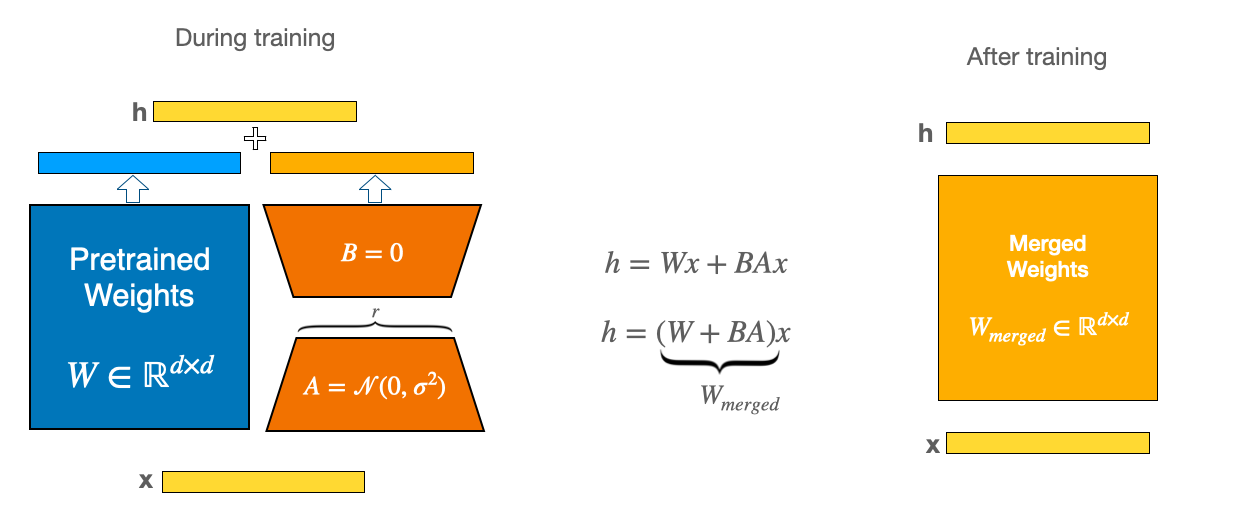

### 全局参数设置

#### 数据准备
- 下载数据集：训练、验证和评估集
- 预处理数据：降采样、移除不必要字段等
- 数据抽样（演示需要）
- 应用数据集处理
  - 使用 `Dataset.map` 进行数据处理
  - 自定义语音数据处理器

#### 模型准备
- 加载和处理 int8 精度 Whisper-Large-v2 模型
- LoRA Adapter 参数配置
- 实例化 PEFT Model：`peft_model = get_peft_model(model, config)`

#### 模型训练
- 训练参数配置 `Seq2SeqTrainingArguments`
- 实例化训练器 `Seq2SeqTrainer`
- 训练模型
- 保存模型

#### 模型推理
- 使用 PeftModel 加载 LoRA 微调后 Whisper 模型
- 使用 Pipeline API 部署微调后 Whisper 实现中文语音识别任务

### 全局参数设置

In [1]:
model_name_or_path = "openai/whisper-large-v2"
model_dir = "models/whisper-large-v2-asr-int8"

language = "Chinese (China)"
language_abbr = "zh-CN"
task = "transcribe"
dataset_name = "mozilla-foundation/common_voice_11_0"
batch_size=16

### 数据准备
下载数据集 Common Voice
Common Voice 11.0 数据集包含许多不同语言的录音，总时长达数小时。

本教程以中文数据为例，展示如何使用 LoRA 在 Whisper-large-v2 上进行微调训练。

首先，初始化一个DatasetDict结构，并将训练集（将训练+验证拆分为训练集）和测试集拆分好，按照中文数据集构建配置加载到内存中：

In [2]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset(dataset_name, language_abbr, split="train", trust_remote_code=True)
common_voice["validation"] = load_dataset(dataset_name, language_abbr, split="validation", trust_remote_code=True)

common_voice["train"][0]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 29056it [00:00, 190500.28it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 10581it [00:00, 206948.65it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 10581it [00:00, 211310.87it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 20637it [00:00, 206357.90it/s]
Reading metadata...: 41273it [00:00, 203018.64it/s]
Reading metadata...: 61579it [00:00, 198034.95it/s]
Reading metadata...: 81395it [00:00, 196327.31it/s]
Reading metadata...: 101034it [00:00, 194183.97it/s]
Reading metadata...: 120535it [00:00, 194449.29it/s]
Reading metadata...: 140021it [00:00, 194578.23it/s]
Reading metadata...: 159739it [00:00, 195394.84it/s]
Reading metadata...: 179281it [00:00, 190931.68it/s]
Reading metadata...: 198915it [00:01, 192556.41it/s]
Reading metadata...: 218327it [00:01, 193025.84it/s]
Reading metadata...: 237756it [00:01, 193404.42it/s]
Reading metadata...: 257106it [00:01, 192659.42it/s]
Reading metadata...: 276689it [00:01, 193605.66it/s]
Reading metadata...: 296055it [00:01, 193146.38it/s]
Reading metadata...: 315374it [00:01, 192752.15it/s]
Reading metadata...: 334652it [00:01, 192580.63it/s]
Reading metadata...: 353912it [00:01, 183921.91it/s]
Reading m

Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 21302it [00:00, 207850.57it/s]


{'client_id': '95368aab163e0387e4fd4991b4f2d8ccfbd4364bf656c860230501fd27dcedf087773e4695a6cf5de9c4f1d406d582283190d065cdfa36b0e2b060cffaca977e',
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/dcc5967c754d4c815fc005d6e297d84537028996cbcf6b34190517630cbc40b4/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/dcc5967c754d4c815fc005d6e297d84537028996cbcf6b34190517630cbc40b4/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
  'array': array([-6.82121026e-13, -2.27373675e-12, -2.27373675e-12, ...,
          1.21667399e-05,  3.23003678e-06, -2.43066324e-07]),
  'sampling_rate': 48000},
 'sentence': '性喜温暖润湿气候且耐寒。',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'zh-CN',
 'segment': ''}

### 预处理训练数据集

In [3]:
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor

# 从预训练模型加载特征提取器
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)

# 从预训练模型加载分词器，可以指定语言和任务以获得最适合特定需求的分词器配置
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, language=language, task=task)

# 从预训练模型加载处理器，处理器通常结合了特征提取器和分词器，为特定任务提供一站式的数据预处理
processor = AutoProcessor.from_pretrained(
    model_name_or_path, language=language, task=task)

/root/miniconda3/envs/transformers/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-02-28 14:07:59.638571: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 14:08:00.124831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 14:08:00.124915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 14:08

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

### 移除数据集中不必要的字段

In [4]:
common_voice = common_voice.remove_columns(
    ["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"]
)

In [5]:
common_voice["train"][0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/dcc5967c754d4c815fc005d6e297d84537028996cbcf6b34190517630cbc40b4/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
  'array': array([-6.82121026e-13, -2.27373675e-12, -2.27373675e-12, ...,
          1.21667399e-05,  3.23003678e-06, -2.43066324e-07]),
  'sampling_rate': 48000},
 'sentence': '性喜温暖润湿气候且耐寒。'}

### 降采样音频数据
查看common_voice 数据集介绍，你会发现其音频是以48kHz的采样率进行采样的.

而Whisper模型是在16kHZ的音频输入上预训练的，因此我们需要将音频输入降采样以匹配模型预训练时使用的采样率。

通过在音频列上使用cast_column方法，并将sampling_rate设置为16kHz来对音频进行降采样。

下次调用时，音频输入将实时重新取样：

In [6]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [7]:
# sampling_rate 从 48KHZ 降为 16KHZ
common_voice["train"][0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/dcc5967c754d4c815fc005d6e297d84537028996cbcf6b34190517630cbc40b4/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
  'array': array([ 5.09317033e-11, -7.27595761e-12, -6.54836185e-11, ...,
         -5.96661994e-06,  2.71382887e-05,  1.29687978e-05]),
  'sampling_rate': 16000},
 'sentence': '性喜温暖润湿气候且耐寒。'}

#### 整合以上数据处理为一个函数
该数据预处理函数应该包括：

- 通过加载音频列将音频输入重新采样为16kHZ。
- 使用特征提取器从音频数组计算输入特征。
- 将句子列标记化为输入标签。

In [8]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

### 数据抽样（选取1600个训练样本，800个验证样本作为homework，NVIDIA T4 显卡上耗时约30-40分钟。PS：全部样例需要训练6个小时左右）
在 Whisper-Large-v2 上使用小规模数据进行演示训练，保持以下训练参数不变（batch_size=16，PS：设置为64时，16G显存刷爆了）。

使用 1600 个样本训练，800个样本验证和评估，恰好使得1个 epoch 仅需100 steps 即可完成训练。

In [26]:
small_common_voice = DatasetDict()

small_common_voice["train"] = common_voice["train"].shuffle(seed=16).select(range(1600))
small_common_voice["validation"] = common_voice["validation"].shuffle(seed=16).select(range(800))

In [27]:
small_common_voice

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 1600
    })
    validation: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 800
    })
})

### 如果全量训练，则使用完整数据代替抽样

In [28]:
# 抽样数据处理
tokenized_common_voice = small_common_voice.map(prepare_dataset)

#完整数据训练，尝试开启 `num_proc=8` 参数多进程并行处理（如阻塞无法运行，则不使用此参数）
# tokenized_common_voice = common_voice.map(prepare_dataset)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [29]:
tokenized_common_voice

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'input_features', 'labels'],
        num_rows: 1600
    })
    validation: Dataset({
        features: ['audio', 'sentence', 'input_features', 'labels'],
        num_rows: 800
    })
})

### 自定义语音数据整理器
定义了一个针对语音到文本（Seq2Seq）模型的自定义数据整理器类，特别适用于输入为语音特征、输出为文本序列的数据集。

这个整理器（DataCollatorSpeechSeq2SeqWithPadding）旨在将数据点批量打包，将每个批次中的attention_mask填充到最大长度，以保持批处理中张量形状的一致性，并用-100替换填充值，以便在损失函数中被忽略。这对于神经网络的高效训练至关重要。

In [30]:

import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

# 定义一个针对语音到文本任务的数据整理器类
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any  # 处理器结合了特征提取器和分词器

    # 整理器函数，将特征列表处理成一个批次
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 从特征列表中提取输入特征，并填充以使它们具有相同的形状
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 从特征列表中提取标签特征（文本令牌），并进行填充
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 使用-100替换标签中的填充区域，-100通常用于在损失计算中忽略填充令牌
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # 如果批次中的所有序列都以句子开始令牌开头，则移除它
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        # 将处理过的标签添加到批次中
        batch["labels"] = labels

        return batch  # 返回最终的批次，准备好进行训练或评估

In [31]:
# 用给定的处理器实例化数据整理器
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

## 模型准备
加载预训练模型（int8 精度）
使用 int8  精度加载预训练模型，进一步降低显存需求。

In [32]:
from transformers import AutoModelForSpeechSeq2Seq
model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name_or_path, load_in_8bit=True, device_map="auto")

In [33]:
# 设置模型配置中的forced_decoder_ids属性为None
model.config.forced_decoder_ids = None  # 这通常用于指定在解码（生成文本）过程中必须使用的特定token的ID，设置为None表示没有这样的强制要求

# 设置模型配置中的suppress_tokens列表为空
model.config.suppress_tokens = []  # 这用于指定在生成过程中应被抑制（不生成）的token的列表，设置为空列表表示没有要抑制的token

### PEFT 微调前的模型处理
在使用 peft 训练 int8 模型之前，需要进行一些预处理：

- 将所有非 int8 精度模块转换为全精度（fp32）以保证稳定性
- 为输入嵌入层添加一个 forward_hook，以启用输入隐藏状态的梯度计算
- 启用梯度检查点以实现更高效的内存训练

使用 peft 库预定义的工具函数 prepare_model_for_int8_training，便可自动完成以上模型处理工作。

In [34]:
from peft import prepare_model_for_int8_training

model = prepare_model_for_int8_training(model)

/root/miniconda3/envs/transformers/lib/python3.11/site-packages/peft/utils/other.py:143: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


## LoRA Adapter 配置

在 peft 中使用LoRA非常简捷，借助 PeftModel抽象，我们可以快速使用低秩适配器（LoRA）到任意模型。

通过使用 peft 中的 get_peft_model 工具函数来实现。

#### 关于 LoRA 超参数的说明：

MatMul(B,A) * Scaling

Scaling = LoRA_Alpha / Rank

In [35]:
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

# 创建一个LoraConfig对象，用于设置LoRA（Low-Rank Adaptation）的配置参数
config = LoraConfig(
    r=4,  # LoRA的秩，影响LoRA矩阵的大小
    lora_alpha=64,  # LoRA适应的比例因子
    # 指定将LoRA应用到的模型模块，通常是attention和全连接层的投影。
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,  # 在LoRA模块中使用的dropout率
    bias="none",  # 设置bias的使用方式，这里没有使用bias
)
# 将LoRA配置应用到模型配置中
config.low_rank_adapters = config

### 使用get_peft_model函数和给定的配置来获取一个PEFT模型

In [36]:
peft_model = get_peft_model(model, config)

In [37]:
# 打印 LoRA 微调训练的模型参数
peft_model.print_trainable_parameters()

trainable params: 1,966,080 || all params: 1,545,271,040 || trainable%: 0.12723204856023188


### 模型训练
#### Seq2SeqTrainingArguments 训练参数
关于设置训练步数和评估步数

基于 epochs 设置：

num_train_epochs=3,  # 训练的总轮数

    evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估
    
    warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练

基于 steps 设置：

    max_steps=100, # 训练总步数
    
    evaluation_strategy="steps", 
    
    eval_steps=25, # 评估步数

In [38]:
from transformers import Seq2SeqTrainingArguments

# 设置序列到序列模型训练的参数
training_args = Seq2SeqTrainingArguments(
    output_dir=model_dir,  # 指定模型输出和保存的目录
    per_device_train_batch_size=batch_size,  # 每个设备上的训练批量大小
    learning_rate=1e-3,  # 学习率
    num_train_epochs=1,  # 训练的总轮数
    evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估
    # warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练
    # fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用
    per_device_eval_batch_size=batch_size,  # 每个设备上的评估批量大小
    generation_max_length=128,  # 生成任务的最大长度
    logging_steps=10,  # 指定日志记录的步骤，用于跟踪训练进度
    remove_unused_columns=False,  # 是否删除不使用的列，以减少数据处理开销
    label_names=["labels"],  # 指定标签列的名称，用于训练过程中
    # evaluation_strategy="steps",
    # eval_steps=25,
)

### 实例化 Seq2SeqTrainer 训练器

In [39]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=peft_model,
    train_dataset=tokenized_common_voice["train"],
    eval_dataset=tokenized_common_voice["validation"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
)
peft_model.config.use_cache = False

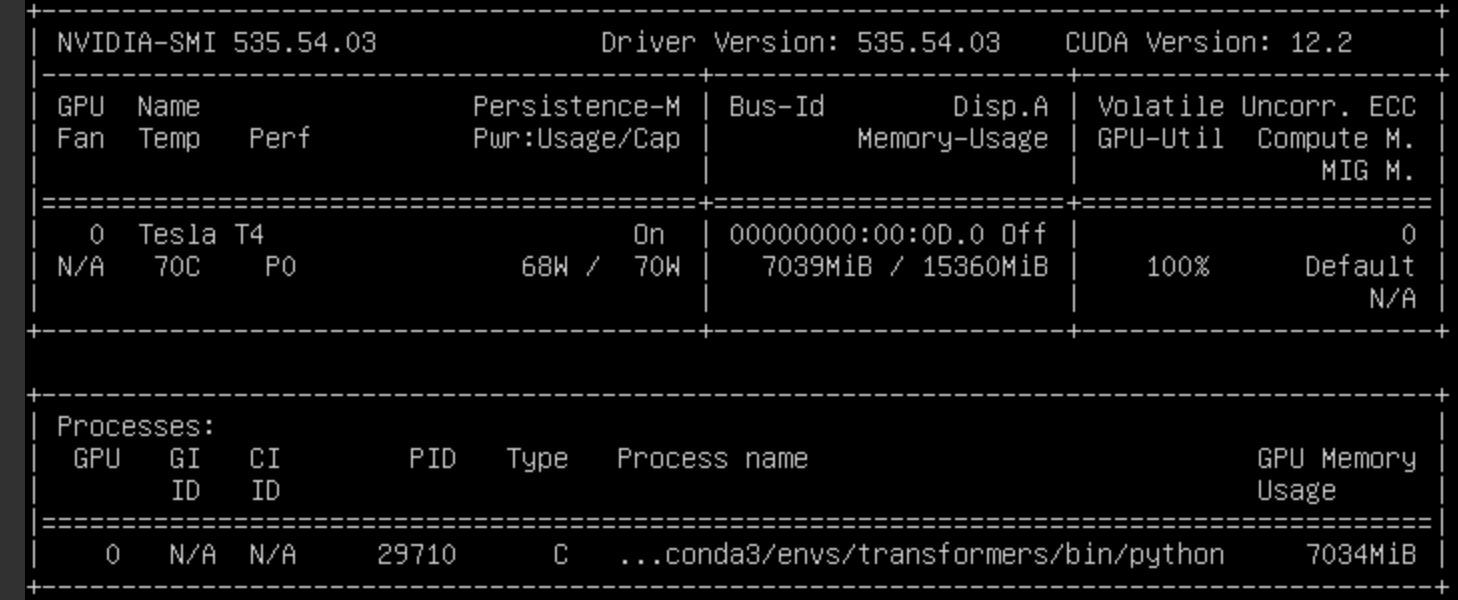

In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.314500,0.442596


TrainOutput(global_step=100, training_loss=0.5525292730331421, metrics={'train_runtime': 1560.9236, 'train_samples_per_second': 1.025, 'train_steps_per_second': 0.064, 'total_flos': 3.4016034816e+18, 'train_loss': 0.5525292730331421, 'epoch': 1.0})

In [41]:
trainer.save_model(model_dir)

In [42]:
peft_model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): WhisperForConditionalGeneration(
      (model): WhisperModel(
        (encoder): WhisperEncoder(
          (conv1): Conv1d(80, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
          (embed_positions): Embedding(1500, 1280)
          (layers): ModuleList(
            (0-31): 32 x WhisperEncoderLayer(
              (self_attn): WhisperSdpaAttention(
                (k_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=False)
                (v_proj): lora.Linear8bitLt(
                  (base_layer): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=4, bias=False)
                  )
            

### 模型推理（可能需要重启 Notebook）
再次加载模型会额外占用显存，如果显存已经达到上限，建议重启 Notebook 后再进行以下操作

使用 PeftModel 加载 LoRA 微调后 Whisper 模型
使用 PeftConfig 加载 LoRA Adapter 配置参数，使用 PeftModel 加载微调后 Whisper 模型

In [1]:
model_dir = "models/whisper-large-v2-asr-int8"

language = "Chinese (China)"
language_abbr = "zh-CN"
language_decode = "chinese"
task = "transcribe"

In [2]:
from transformers import AutoModelForSpeechSeq2Seq, AutoTokenizer, AutoProcessor
from peft import PeftConfig, PeftModel

peft_config = PeftConfig.from_pretrained(model_dir)

base_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    peft_config.base_model_name_or_path, load_in_8bit=True, device_map="auto"
)

peft_model = PeftModel.from_pretrained(base_model, model_dir)

/root/miniconda3/envs/transformers/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-02-28 23:43:03.612565: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 23:43:04.073985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 23:43:04.074064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 23:43

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/4.29k [00:00<?, ?B/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
processor = AutoProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
feature_extractor = processor.feature_extractor

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

### 使用 Pipeline API 部署微调后 Whisper 实现中文语音识别任务

In [4]:
test_audio = "data/audio/mlk.flac"

In [5]:
from transformers import AutomaticSpeechRecognitionPipeline

pipeline = AutomaticSpeechRecognitionPipeline(model=peft_model, tokenizer=tokenizer, feature_extractor=feature_extractor)

forced_decoder_ids = processor.get_decoder_prompt_ids(language=language_decode, task=task)

The model 'PeftModel' is not supported for . Supported models are ['Pop2PianoForConditionalGeneration', 'SeamlessM4TForSpeechToText', 'SeamlessM4Tv2ForSpeechToText', 'SpeechEncoderDecoderModel', 'Speech2TextForConditionalGeneration', 'SpeechT5ForSpeechToText', 'WhisperForConditionalGeneration', 'Data2VecAudioForCTC', 'HubertForCTC', 'MCTCTForCTC', 'SEWForCTC', 'SEWDForCTC', 'UniSpeechForCTC', 'UniSpeechSatForCTC', 'Wav2Vec2ForCTC', 'Wav2Vec2ConformerForCTC', 'WavLMForCTC'].


In [6]:
import torch

with torch.cuda.amp.autocast():
    text = pipeline(test_audio, max_new_tokens=255)["text"]

/root/miniconda3/envs/transformers/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [7]:
text

' I have a dream that one day this nation will rise up and live out the true meaning of its creed.'